In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator 
from yellowbrick.cluster import silhouette_visualizer 
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.datasets import make_blobs

from decimal import Decimal

In [5]:
data = pd.read_csv('../data/bike_clean.csv')

In [6]:
data.head()

,Unnamed: 0,datetime,date,hour,season,holiday,open,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall
0,1,2017-12-01 00:00:00,2017-12-01,0,Winter,No Holiday,Yes,254,-5.2,37,2.2,20000,-17.6,0.0,0.0,0
1,2,2017-12-01 01:00:00,2017-12-01,1,Winter,No Holiday,Yes,204,-5.5,38,0.8,20000,-17.6,0.0,0.0,0
2,3,2017-12-01 02:00:00,2017-12-01,2,Winter,No Holiday,Yes,173,-6.0,39,1.0,20000,-17.7,0.0,0.0,0
3,4,2017-12-01 03:00:00,2017-12-01,3,Winter,No Holiday,Yes,107,-6.2,40,0.9,20000,-17.6,0.0,0.0,0
4,5,2017-12-01 04:00:00,2017-12-01,4,Winter,No Holiday,Yes,78,-6.0,36,2.3,20000,-18.6,0.0,0.0,0


In [ ]:
Xy_,clusters_ = make_blobs(n_samples=4000, centers=5, cluster_std=0.7)
df_ = pd.DataFrame(Xy_,columns=['X','Y'])
df_['K'] = clusters_
sns.scatterplot(x='X',y='Y',hue='K',data=df_);

## K means clustering
### Scaling Data

In [7]:
df_kmean = data.drop(columns = ['Unnamed: 0', 'season', 'holiday','open', 'datetime', 'date'])

In [8]:
dataarray = df_kmean.to_numpy()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataarray) 
scaled_features

array([[-1.66132477, -0.69865046, -1.51395724, ..., -0.65513172,
        -0.13179988, -0.17189109],
       [-1.51686175, -0.77617457, -1.53907415, ..., -0.65513172,
        -0.13179988, -0.17189109],
       [-1.37239873, -0.82423951, -1.58093567, ..., -0.65513172,
        -0.13179988, -0.17189109],
       ...,
       [ 1.37239873, -0.0164383 , -0.86091752, ..., -0.65513172,
        -0.13179988, -0.17189109],
       [ 1.51686175,  0.01147038, -0.90277904, ..., -0.65513172,
        -0.13179988, -0.17189109],
       [ 1.66132477, -0.18699134, -0.91952365, ..., -0.65513172,
        -0.13179988, -0.17189109]])

### Evaluating WCSS

In [9]:
wcss = []
max_k = 14
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

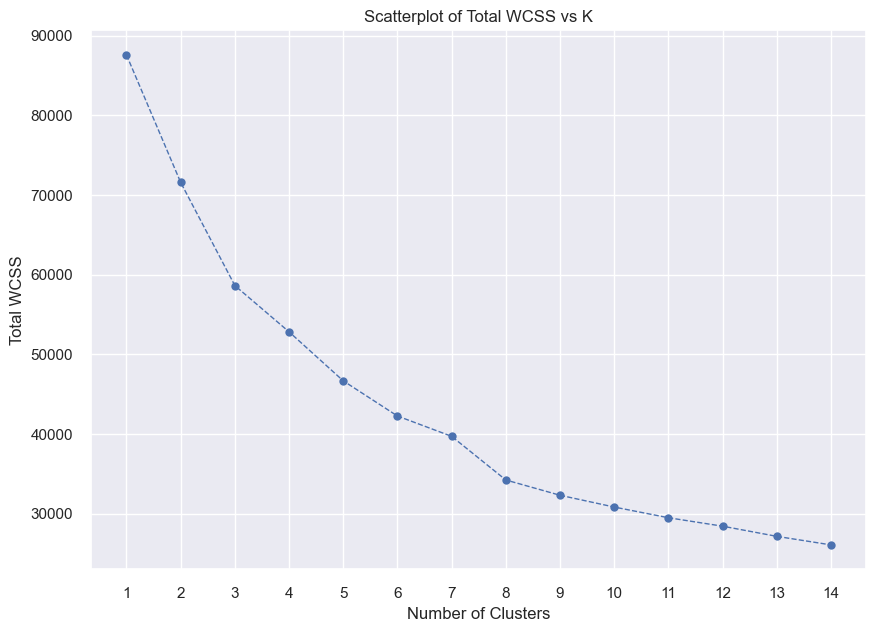

In [10]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [11]:
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

kl.elbow

8

In [12]:
silhouette_coefficients = []

for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)

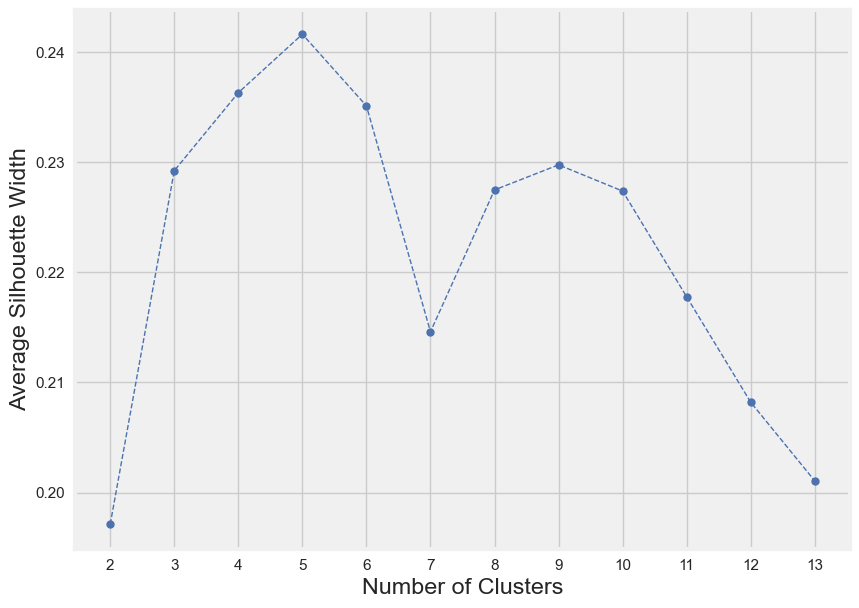

In [13]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

In [14]:
silhouette_dict = {}
def kmeans_label(data, num_clusters): 
    kmeans_model = KMeans(init = 'random', n_clusters = num_clusters, random_state=42)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data.to_numpy()) 
    kmeans_model.fit(scaled_features)
    data2 = data.copy()
    labels = kmeans_model.labels_
    data2['Clusters'] = pd.DataFrame(labels)
    return data2

def plot_boxplots(data_with_label):
    plt.figure(figsize=(30,30))
    sns.set(font_scale = 2)
    for i in range(len(data_with_label.columns)-1):
        plt.subplot(2,5,i+1)
        sns.boxplot(y=data_with_label.columns[i], x='Clusters', data=data_with_label, palette="colorblind") 
    
def plot_silhouettes(data,num_clusters):
    scaler = StandardScaler()
    dataarray = scaler.fit_transform(data.to_numpy()) 
    model = KMeans(num_clusters,random_state=42)
    plt.figure(figsize=(10, 7)) 
    sns.set(font_scale = 1)
    silhouette_visualizer(model, dataarray, colors='yellowbrick')
    score = silhouette_score(dataarray, model.labels_,metric = 'euclidean')
    if num_clusters not in silhouette_dict.keys():
        silhouette_dict[num_clusters] = score
    print("For n_clusters = {0} The average silhouette_score is: {1} ".format(num_clusters,score))

### Kmeans with 3 clusters

In [15]:
kmeans3 = KMeans(init="random",n_clusters =3 , random_state = 42)
kmeans3.fit(scaled_features)
clustergroups3 = kmeans3.labels_
Clustercenters3 = pd.DataFrame(kmeans3.cluster_centers_)
Clustercenters3

print(f'CH score: {calinski_harabasz_score(scaled_features, clustergroups3)}')

CH score: 2162.5346475800516


In [16]:
model3 = kmeans_label(df_kmean, 3)
model3.head()

,hour,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall,Clusters
0,0,254,-5.2,37,2.2,20000,-17.6,0.0,0.0,0,2
1,1,204,-5.5,38,0.8,20000,-17.6,0.0,0.0,0,2
2,2,173,-6.0,39,1.0,20000,-17.7,0.0,0.0,0,2
3,3,107,-6.2,40,0.9,20000,-17.6,0.0,0.0,0,2
4,4,78,-6.0,36,2.3,20000,-18.6,0.0,0.0,0,2


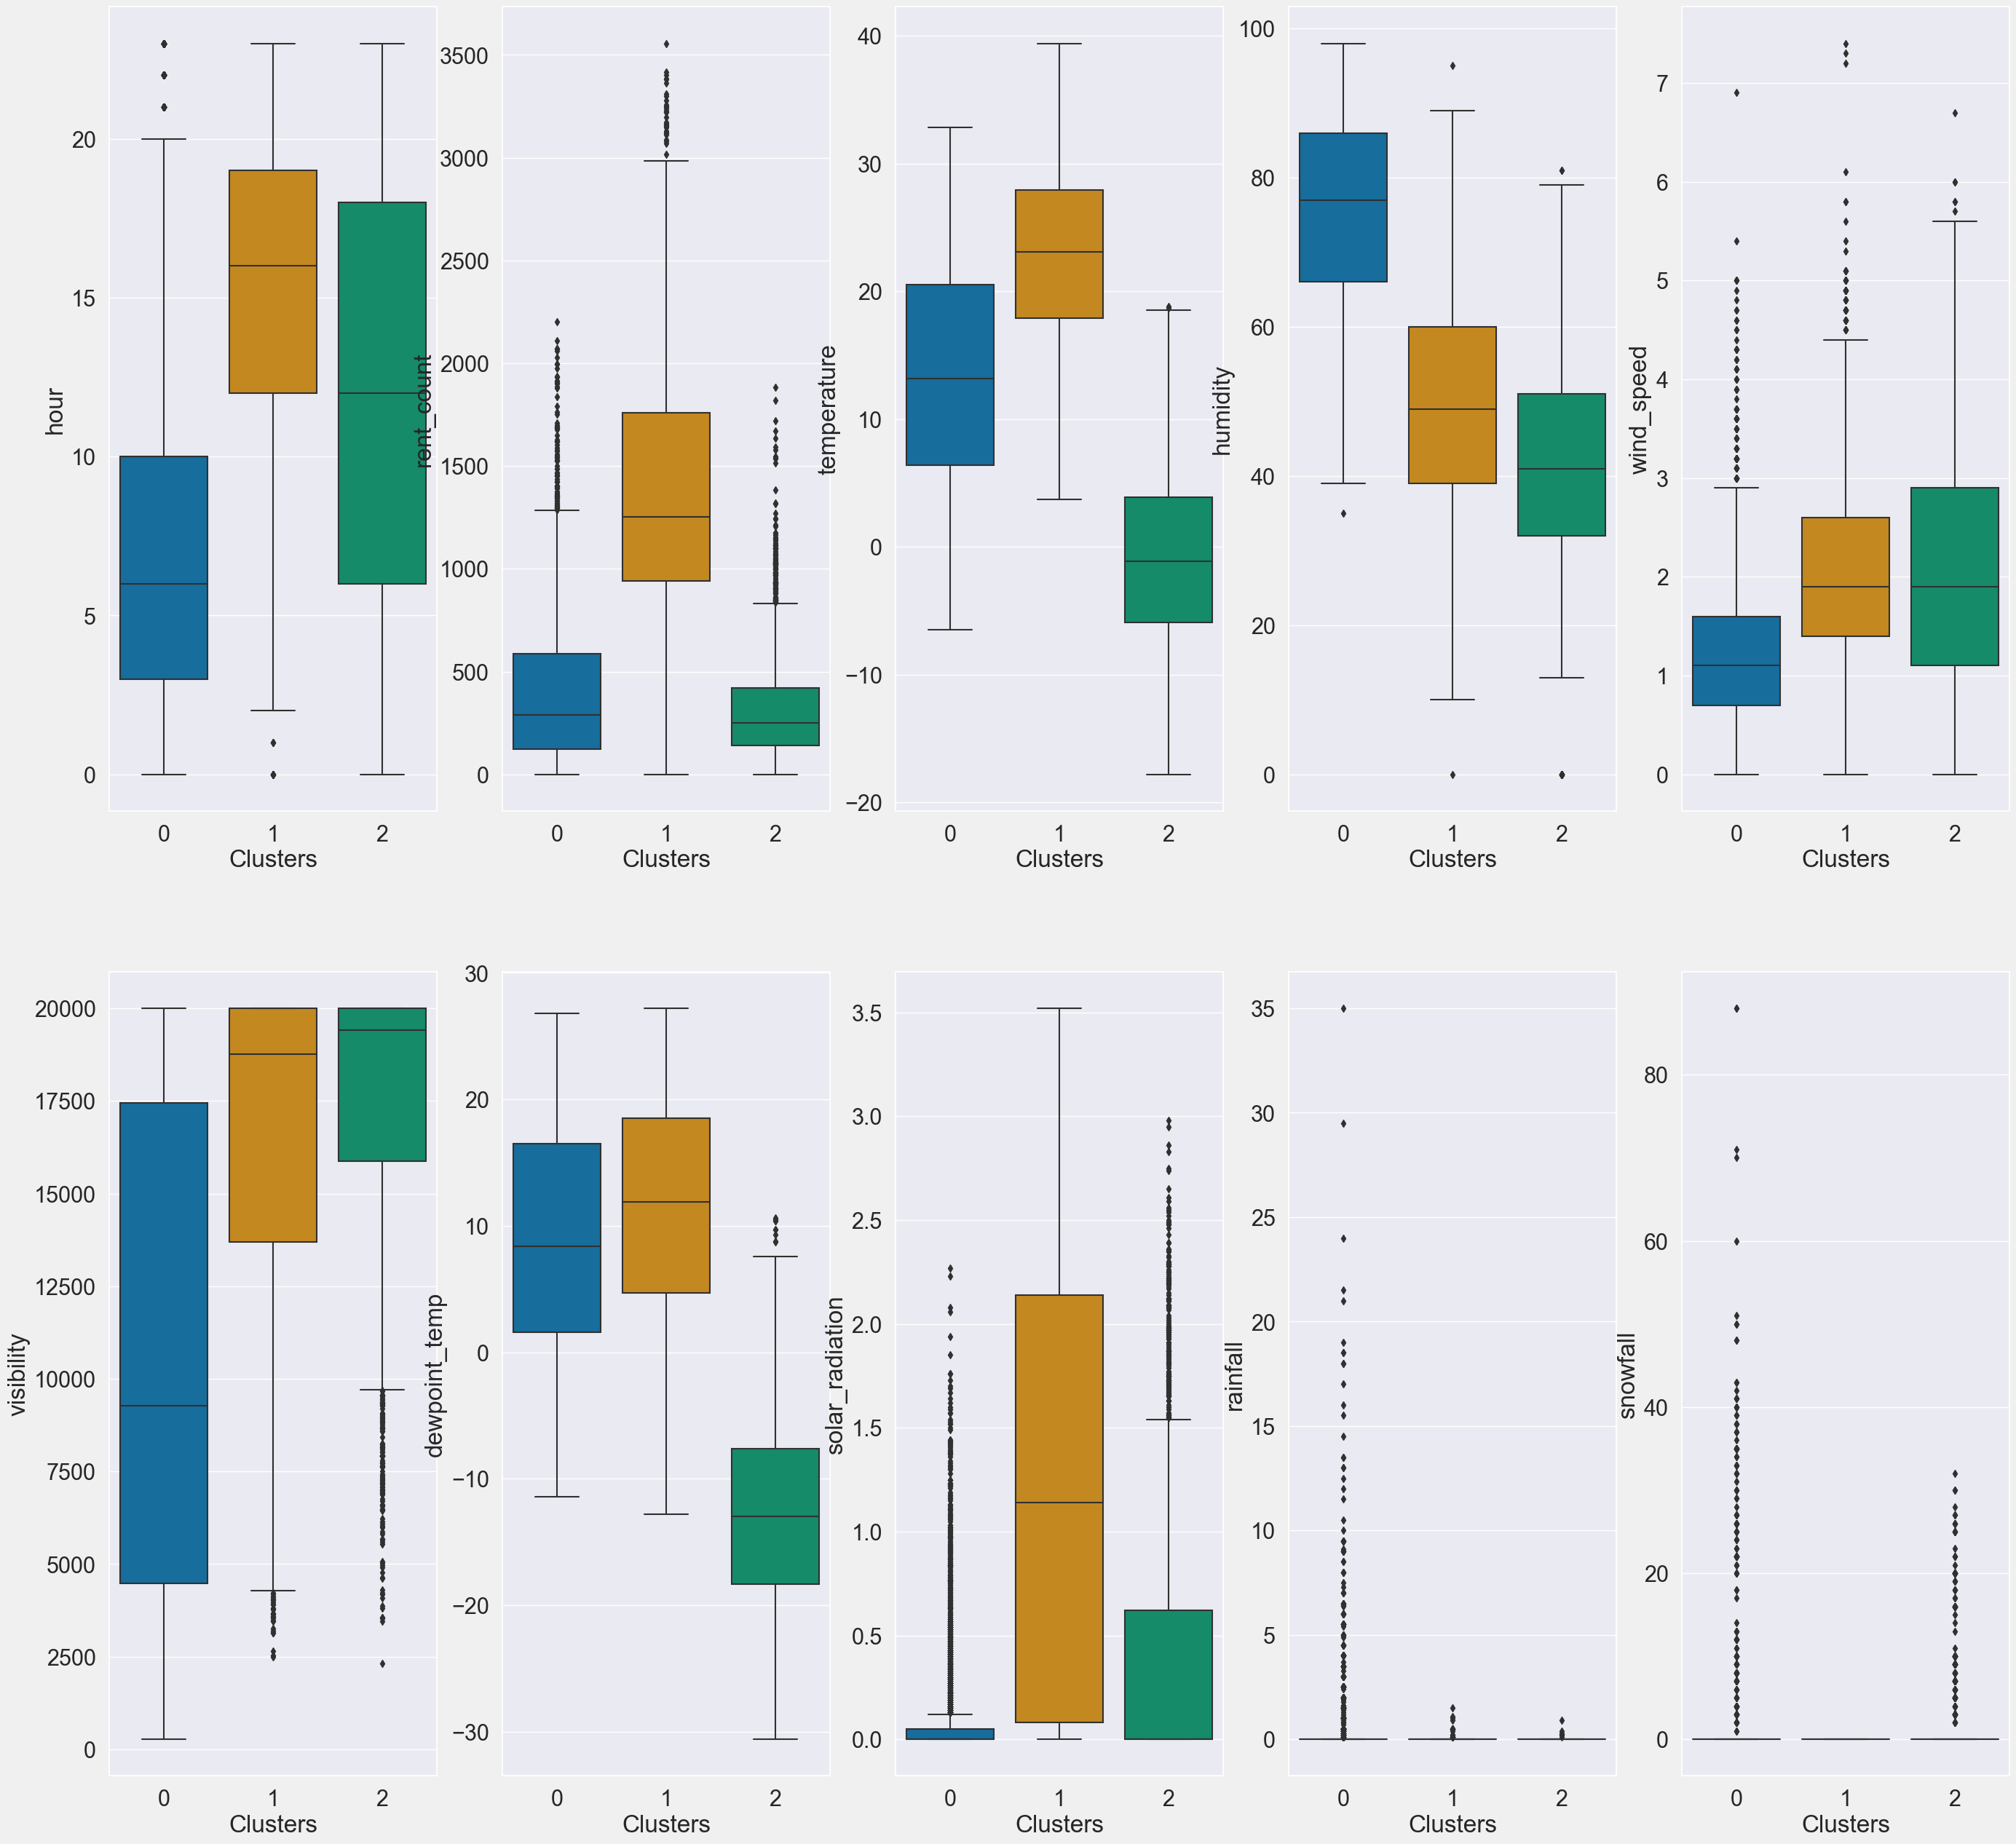

In [17]:
plot_boxplots(model3)
plt.show()

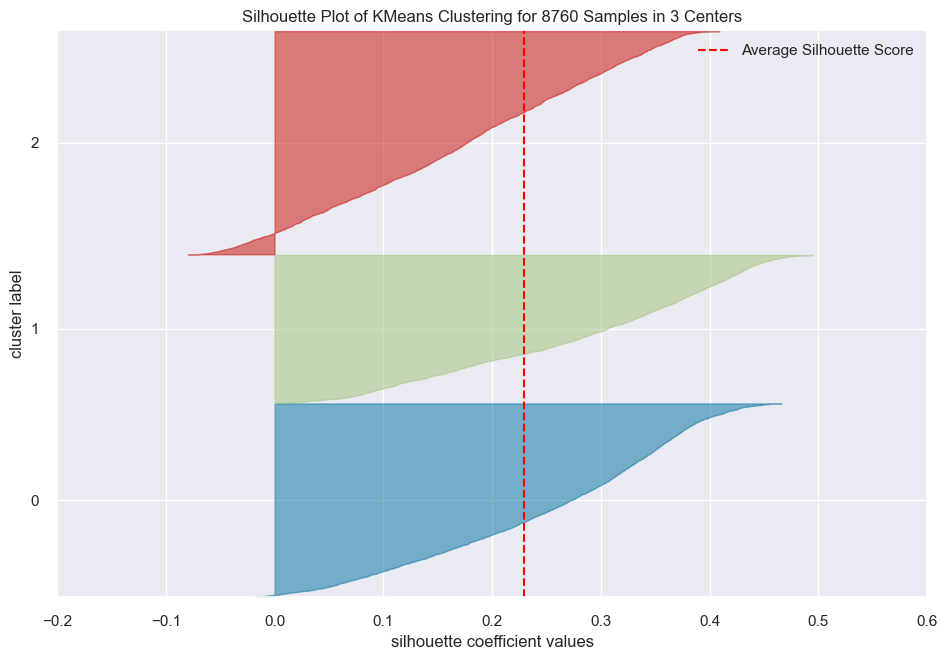

For n_clusters = 3 The average silhouette_score is: 0.22923396348047517 


In [18]:
plot_silhouettes(df_kmean,3)
plt.show()

### Kmeans with 4 clusters

In [19]:
kmeans4 = KMeans(init="random",n_clusters =4 , random_state = 42)
kmeans4.fit(scaled_features)
clustergroups4 = kmeans4.labels_
Clustercenters4 = pd.DataFrame(kmeans4.cluster_centers_)
Clustercenters4

print(f'CH score: {calinski_harabasz_score(scaled_features, clustergroups4)}')

CH score: 1920.84756747687


In [20]:
model4 = kmeans_label(df_kmean, 4)
model4.head()

,hour,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall,Clusters
0,0,254,-5.2,37,2.2,20000,-17.6,0.0,0.0,0,2
1,1,204,-5.5,38,0.8,20000,-17.6,0.0,0.0,0,2
2,2,173,-6.0,39,1.0,20000,-17.7,0.0,0.0,0,2
3,3,107,-6.2,40,0.9,20000,-17.6,0.0,0.0,0,2
4,4,78,-6.0,36,2.3,20000,-18.6,0.0,0.0,0,2


In [21]:
model4.Clusters.value_counts()

1    3434
0    2979
2    2281
3      66
Name: Clusters, dtype: int64

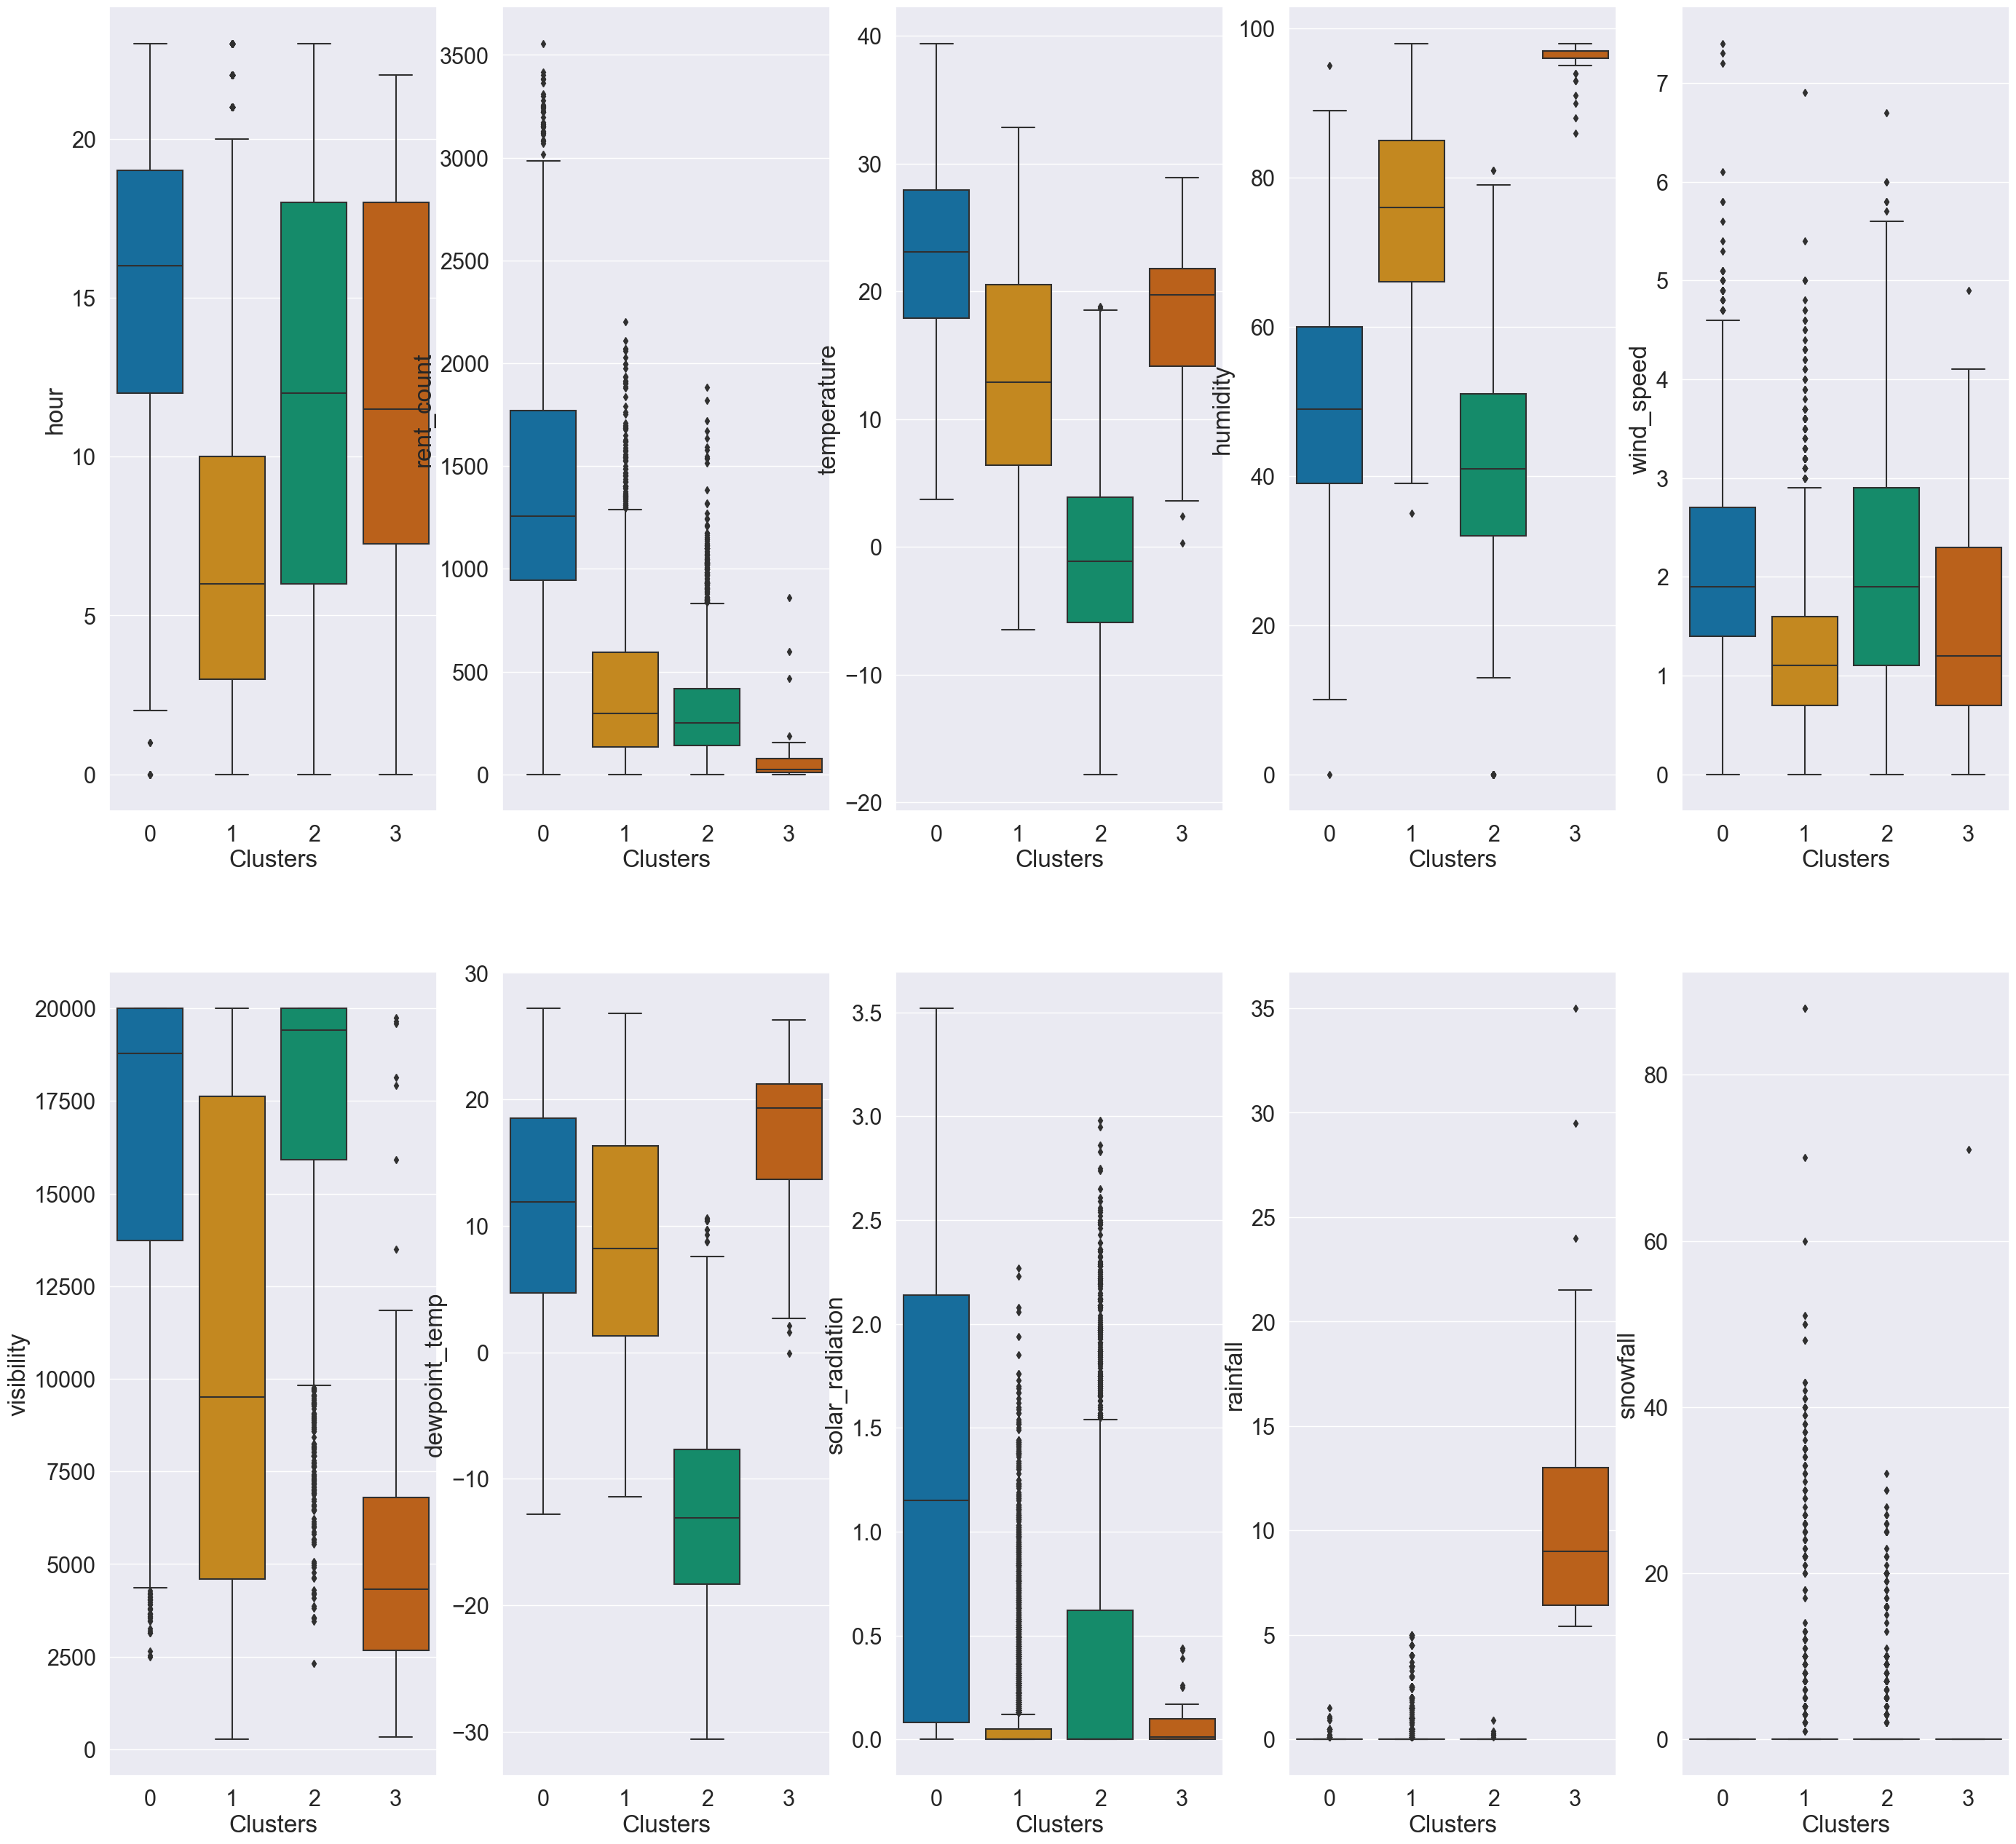

In [22]:
plot_boxplots(model4)
plt.show()

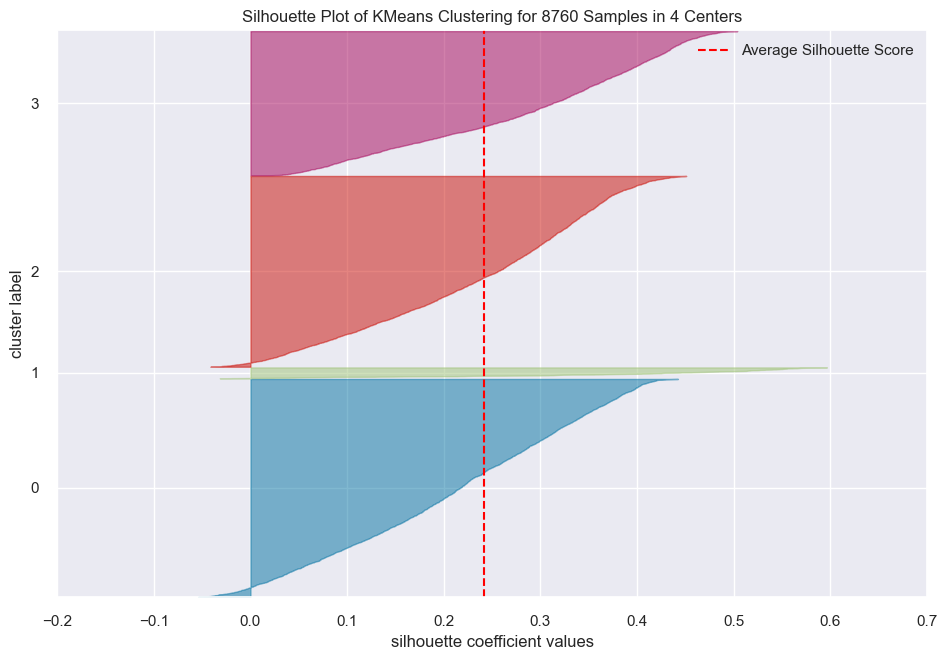

For n_clusters = 4 The average silhouette_score is: 0.24197827933813065 


In [23]:
plot_silhouettes(df_kmean,4)
plt.show()

### Kmeans with 5 clusters

In [24]:
kmeans5 = KMeans(init="random",n_clusters =5 , random_state = 42)
kmeans5.fit(scaled_features)
clustergroups5 = kmeans5.labels_
Clustercenters5 = pd.DataFrame(kmeans5.cluster_centers_)
Clustercenters5

print(f'CH score: {calinski_harabasz_score(scaled_features, clustergroups5)}')

CH score: 1918.7922788669516


In [25]:
model5 = kmeans_label(df_kmean, 5)
model5.head()
model5.Clusters.value_counts()

4    3239
0    2167
3    1628
2    1558
1     168
Name: Clusters, dtype: int64

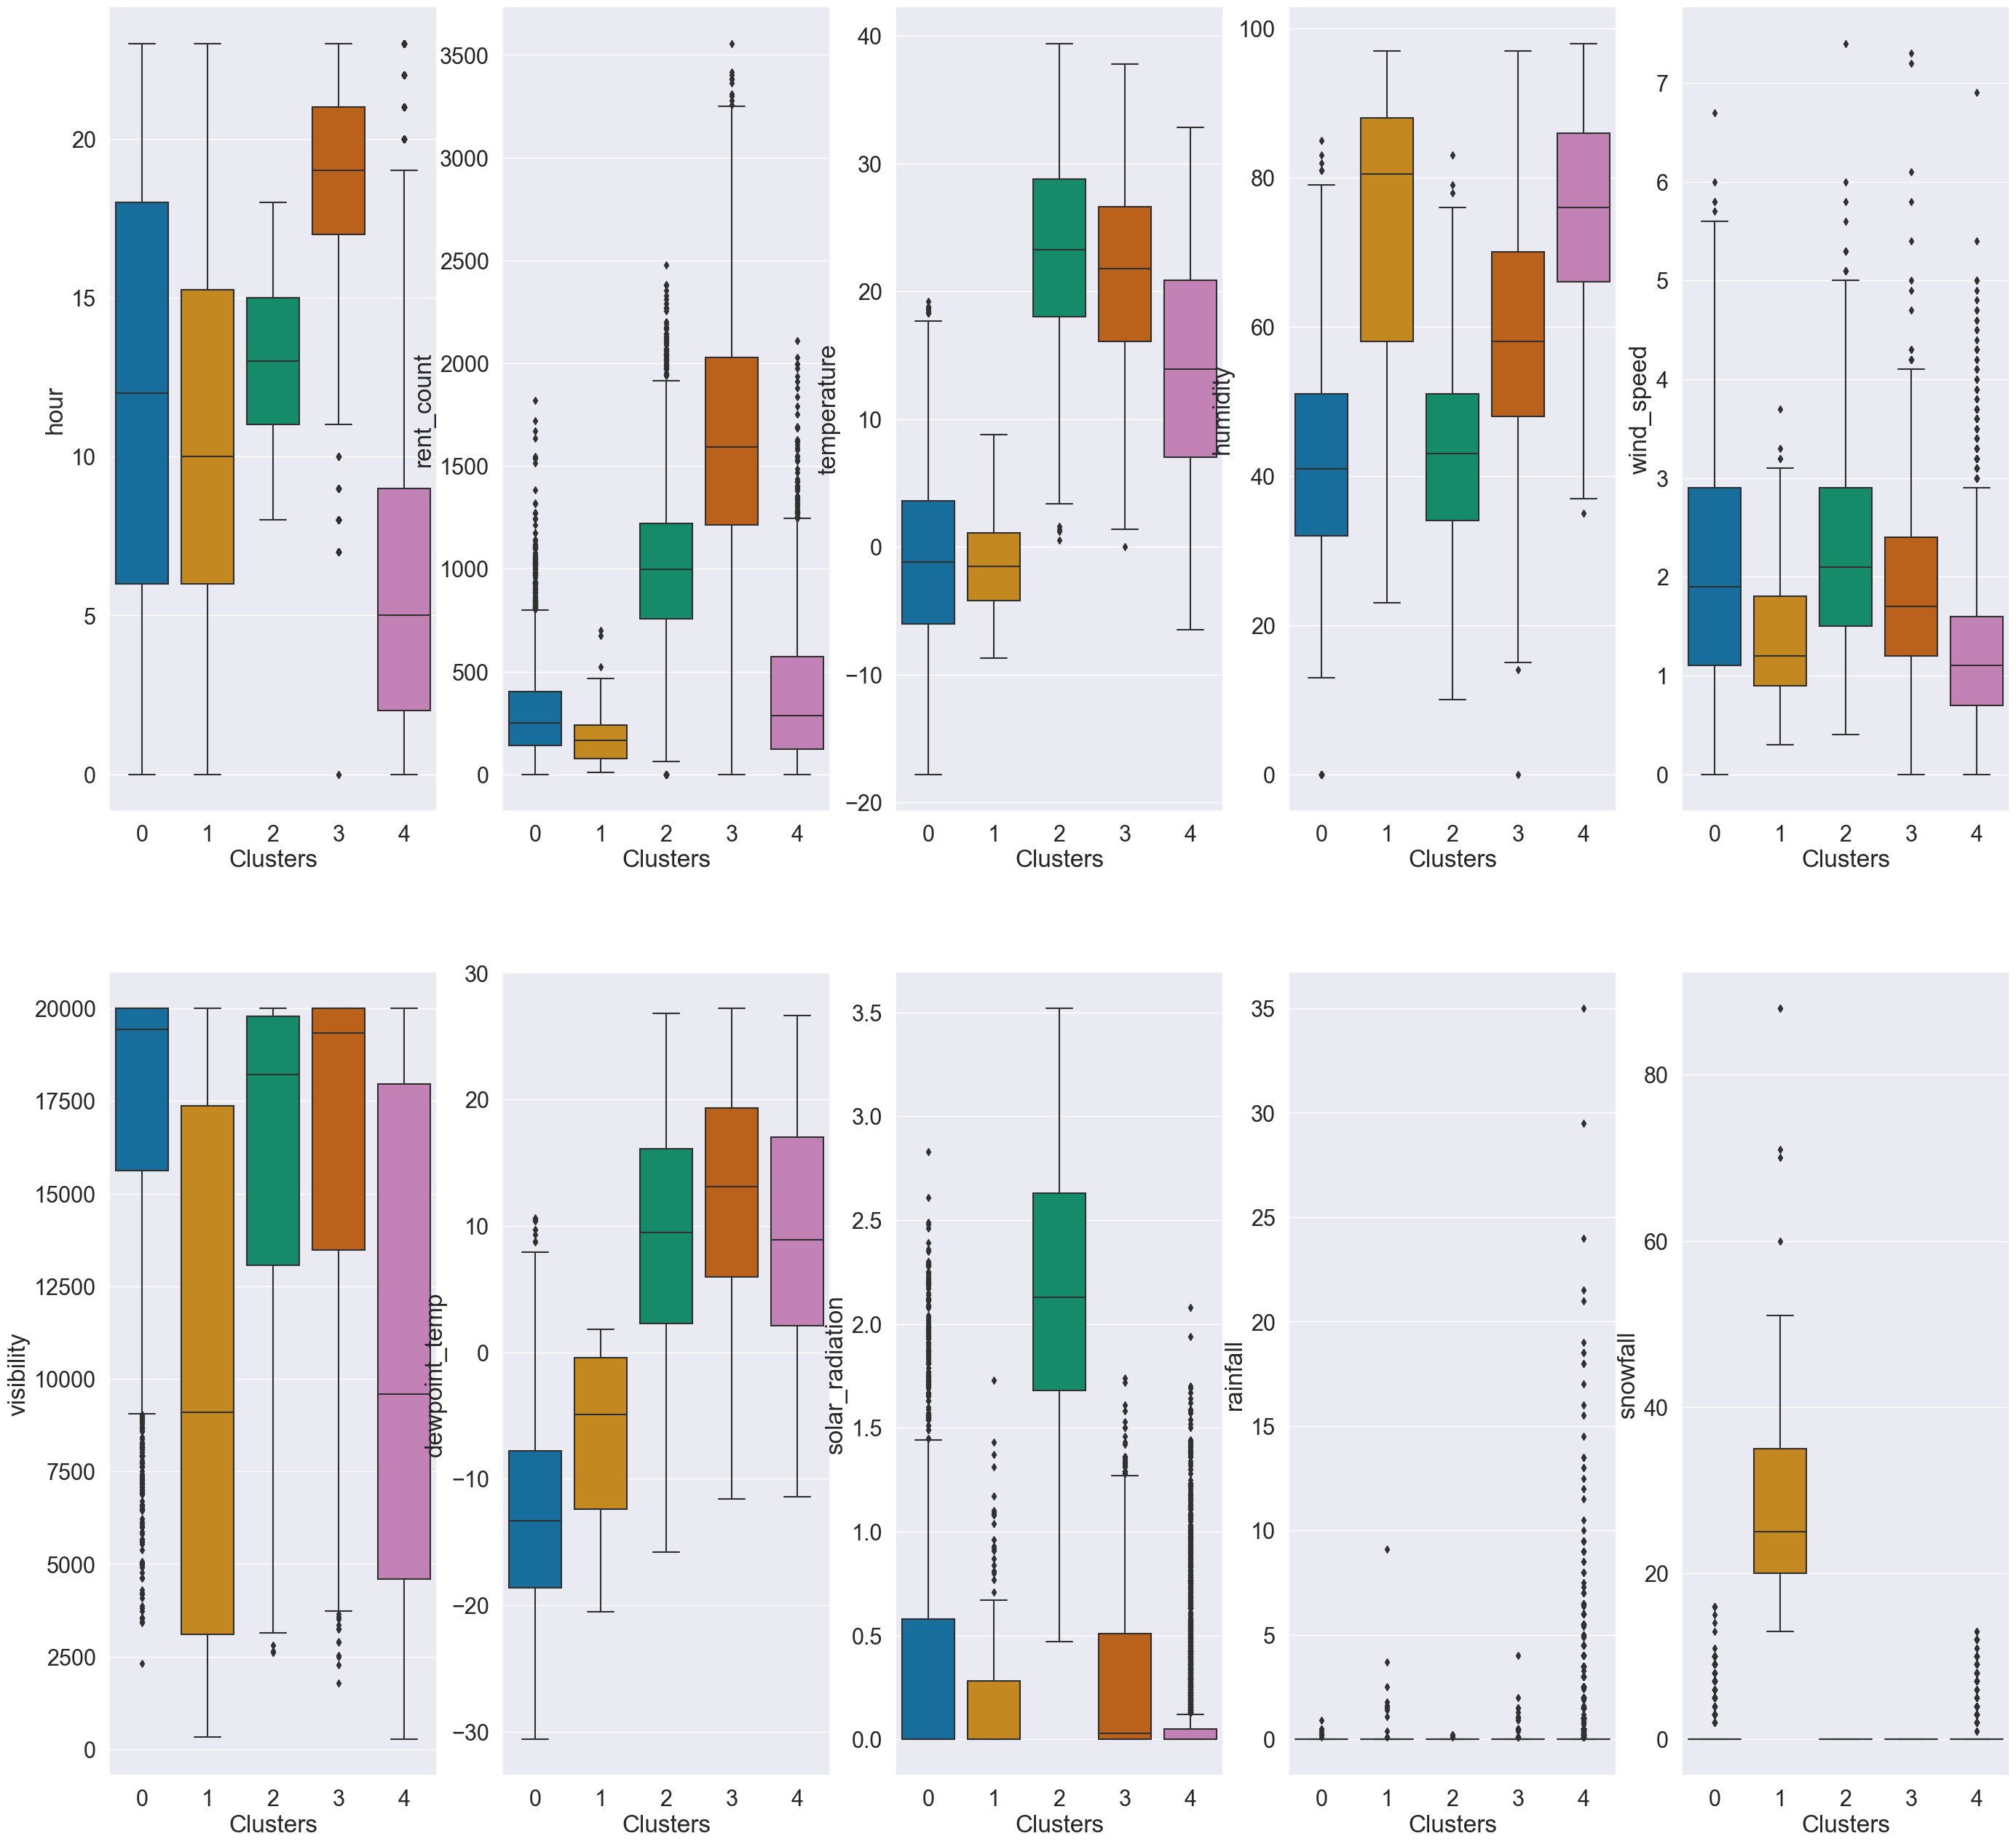

In [26]:
plot_boxplots(model5)
plt.show()

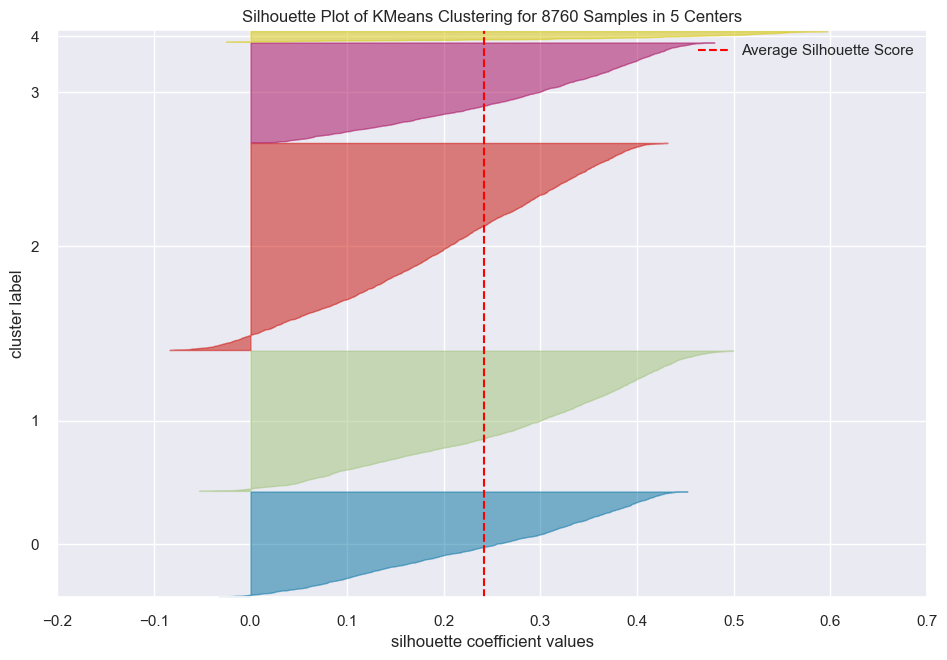

For n_clusters = 5 The average silhouette_score is: 0.24147238601129223 


In [27]:
plot_silhouettes(df_kmean,5)
plt.show()

### Kmeans with 6 clusters

In [28]:
kmeans6 = KMeans(init="random",n_clusters =6 , random_state = 42)
kmeans6.fit(scaled_features)
clustergroups6 = kmeans6.labels_
Clustercenters6 = pd.DataFrame(kmeans6.cluster_centers_)
Clustercenters6

,0,1,2,3,4,5,6,7,8,9
0,0.233345,0.498962,0.860597,-0.767489,0.553651,0.260520,0.391474,1.840979,-0.130929,-0.171891
1,-0.228044,-0.581263,-0.218101,1.069730,-0.334070,-1.471437,0.209450,-0.493454,0.457110,-0.085928
2,-0.969189,-0.360610,0.395081,0.531456,-0.608066,0.405793,0.580232,-0.503386,-0.095473,-0.168624
3,0.092889,-0.607281,-1.216330,-0.859476,0.362020,0.534745,-1.367338,-0.239483,-0.130758,-0.039012
4,1.058572,1.529493,0.714788,-0.016284,0.083339,0.363915,0.628179,-0.329752,-0.120861,-0.171891
5,-0.120096,-0.811593,-1.202770,0.686232,-0.290873,-0.730185,-0.795772,-0.416996,-0.000972,6.307111


In [29]:
model6 = kmeans_label(df_kmean, 6)
model6.head()

,hour,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall,Clusters
0,0,254,-5.2,37,2.2,20000,-17.6,0.0,0.0,0,3
1,1,204,-5.5,38,0.8,20000,-17.6,0.0,0.0,0,3
2,2,173,-6.0,39,1.0,20000,-17.7,0.0,0.0,0,3
3,3,107,-6.2,40,0.9,20000,-17.6,0.0,0.0,0,3
4,4,78,-6.0,36,2.3,20000,-18.6,0.0,0.0,0,3


In [30]:
model6.Clusters.value_counts(dropna=False)

3    2041
1    1781
2    1753
0    1527
4    1492
5     166
Name: Clusters, dtype: int64

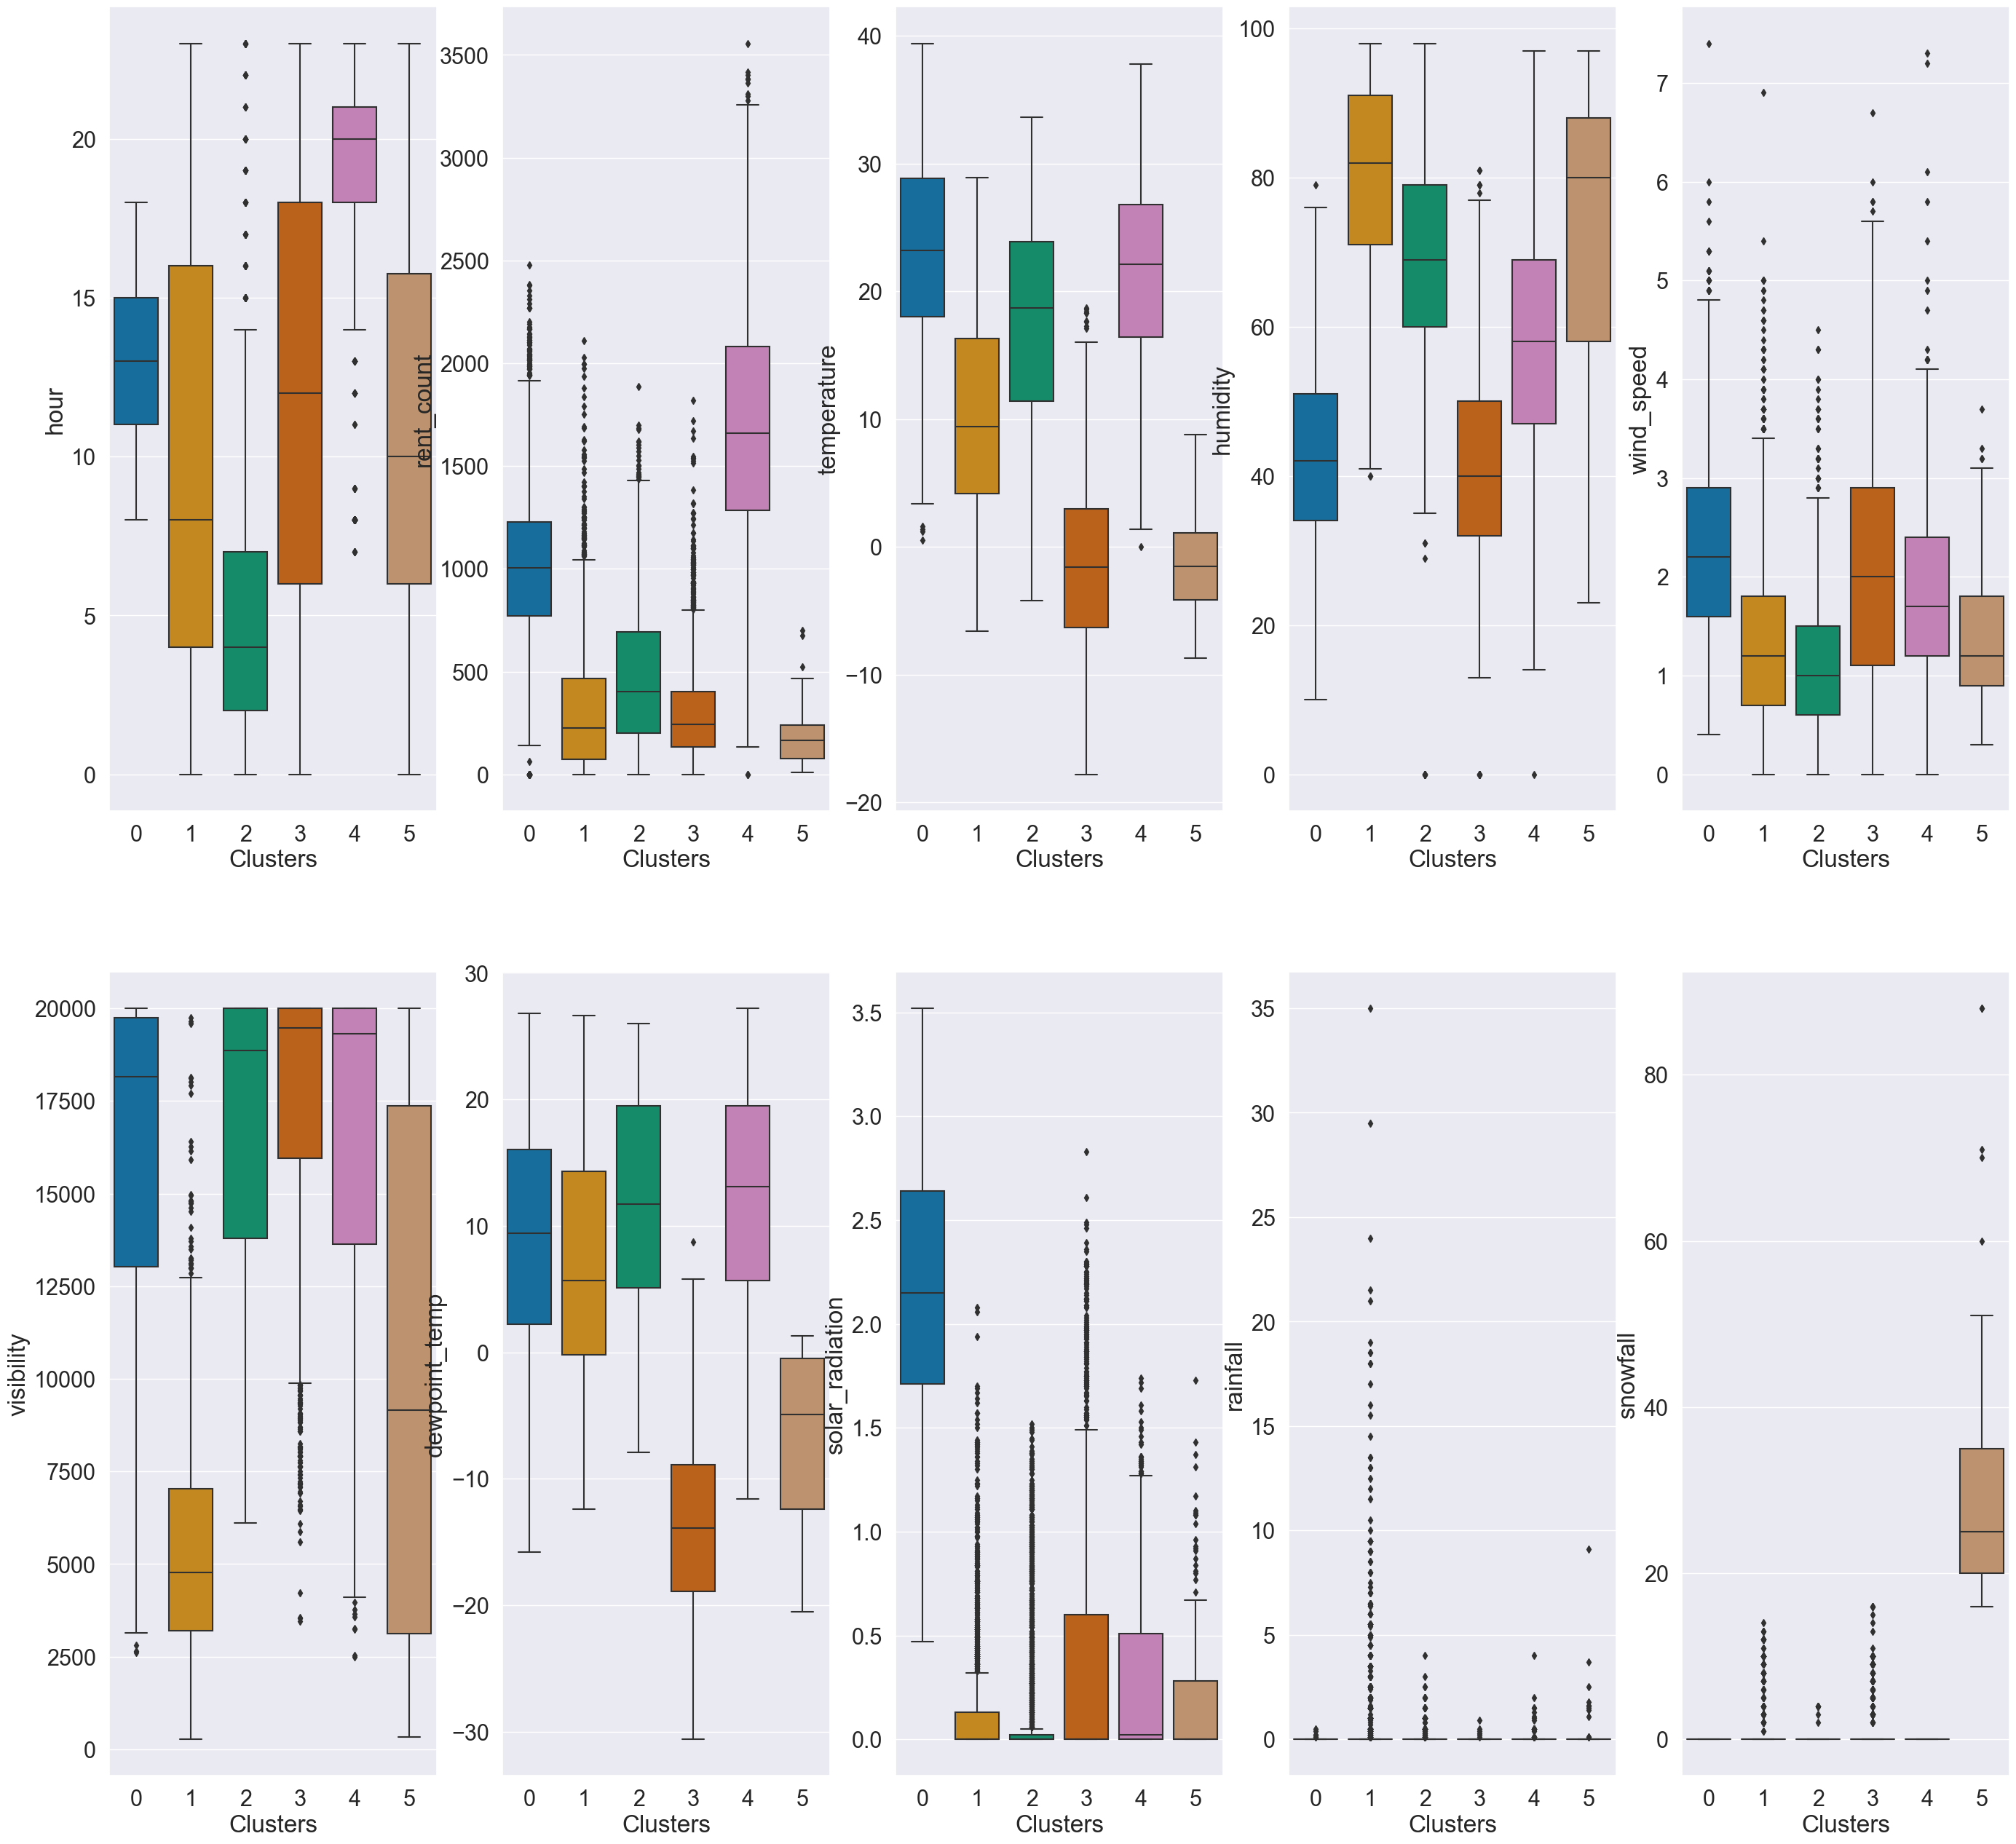

In [31]:
plot_boxplots(model6)
plt.show()

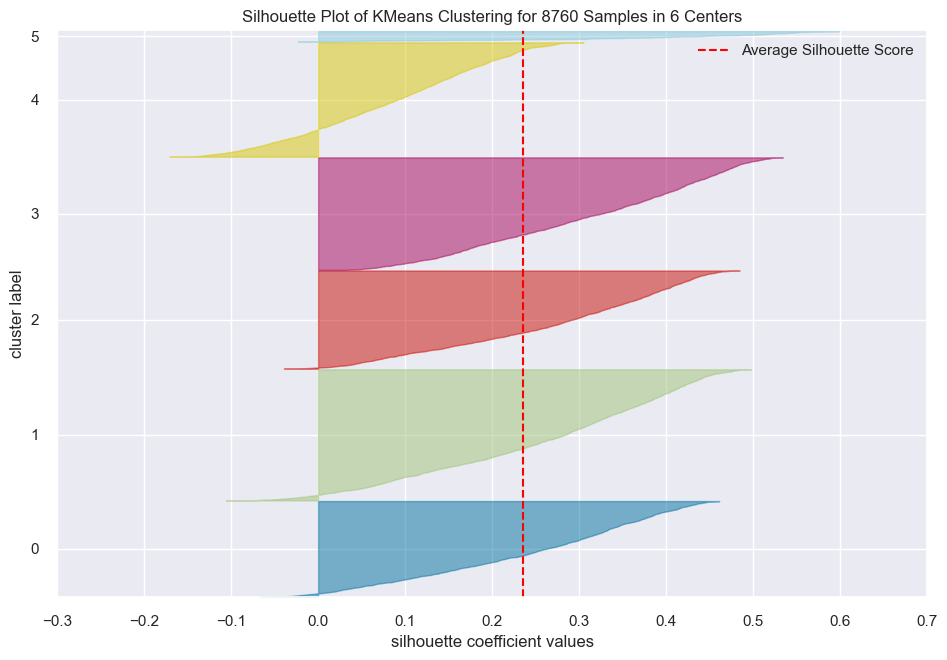

For n_clusters = 6 The average silhouette_score is: 0.23510339433306382 


In [32]:
plot_silhouettes(df_kmean,6)
plt.show()

## Summary
#### Silhouette Coefficient: a higher Silhouette Coefficient score relates to a model with better defined clusters.       
#### Calinski Harabasz Score: also known as the Variance Ratio Criterion, is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters, the higher the score , the better the performances.

In [33]:
kmeans3 = KMeans(init = 'random', n_clusters = 3, random_state=42)
kmeans3.fit(scaled_features)
print('For 3 clusters:')
print(f'CH score: {calinski_harabasz_score(scaled_features, clustergroups3)}')
print(f'Silhouette score: {silhouette_score(scaled_features, clustergroups3, metric = "euclidean")}')

For 3 clusters:
CH score: 2162.5346475800516
Silhouette score: 0.22923396348047517


In [170]:
model3.Clusters.value_counts(dropna=False)

0    3465
1    3001
2    2294
Name: Clusters, dtype: int64

In [34]:
kmeans4 = KMeans(init = 'random', n_clusters = 4, random_state=42)
kmeans4.fit(scaled_features)
print('For 4 clusters:')
print(f'CH score: {calinski_harabasz_score(scaled_features, clustergroups4)}')
print(f'Silhouette score: {silhouette_score(scaled_features, clustergroups4, metric = "euclidean")}')

For 4 clusters:
CH score: 1920.84756747687
Silhouette score: 0.2363176216991027


In [171]:
model4.Clusters.value_counts(dropna=False)

1    3434
0    2979
2    2281
3      66
Name: Clusters, dtype: int64

In [35]:
kmeans5 = KMeans(init = 'random', n_clusters = 5, random_state=42)
kmeans5.fit(scaled_features)
print('For 5 clusters:')
print(f'CH score: {calinski_harabasz_score(scaled_features, clustergroups5)}')
print(f'Silhouette score: {silhouette_score(scaled_features, clustergroups5, metric = "euclidean")}')

For 5 clusters:
CH score: 1918.7922788669516
Silhouette score: 0.2416300005731074


In [172]:
model5.Clusters.value_counts(dropna=False)

4    3239
0    2167
3    1628
2    1558
1     168
Name: Clusters, dtype: int64

In [36]:
kmeans6 = KMeans(init = 'random', n_clusters = 6, random_state=42)
kmeans6.fit(scaled_features)
print('For 6 clusters:')
print(f'CH score: {calinski_harabasz_score(scaled_features, clustergroups6)}')
print(f'Silhouette score: {silhouette_score(scaled_features, clustergroups6, metric = "euclidean")}')

For 6 clusters:
CH score: 1878.1339574979133
Silhouette score: 0.23512134529116252


In [173]:
model6.Clusters.value_counts(dropna=False)

3    2041
1    1781
2    1753
0    1527
4    1492
5     166
Name: Clusters, dtype: int64

In [37]:
clustergroups3 = kmeans3.labels_
Clustercenters3 = pd.DataFrame(scaler.inverse_transform(kmeans3.cluster_centers_), columns = df_kmean.columns)
Clustercenters3

,hour,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall
0,7.598846,393.507937,13.411948,76.223377,1.200837,10510.473304,9.055815,0.115169,0.372496,1.180664e+00
1,15.541667,1356.744000,22.844233,50.174000,2.056533,16464.976667,11.254367,1.238417,0.003233,6.994405e-15
2,12.106754,321.820044,-0.937124,41.579956,2.082658,17451.947712,-12.834379,0.379564,0.000915,1.082789e+00


### DBSCAN + Gower Distance
for clustering on categorical variables 
https://towardsdatascience.com/clustering-on-numerical-and-categorical-features-6e0ebcf1cbad

In [135]:
# !pip install gower
import gower
from sklearn.cluster import DBSCAN

In [136]:
df_gower = data.drop(columns = ['Unnamed: 0', 'datetime', 'date'])

In [137]:
distance_matrix = gower.gower_matrix(df_gower)
distance_matrix.shape

(8760, 8760)

In [138]:
pd.DataFrame(distance_matrix)

,0,1,2,3,4,5,6,7,8,9,...,8750,8751,8752,8753,8754,8755,8756,8757,8758,8759
0,0.000000,0.020167,0.023694,0.030426,0.021416,0.030408,0.036983,0.047387,0.059187,0.076696,...,0.207091,0.210329,0.202520,0.192319,0.203952,0.189672,0.177697,0.199980,0.201718,0.199192
1,0.020167,0.000000,0.007684,0.012338,0.031925,0.026363,0.028780,0.031462,0.048990,0.060262,...,0.220570,0.223808,0.201446,0.203718,0.211194,0.203151,0.191176,0.182783,0.188678,0.192389
2,0.023694,0.007684,0.000000,0.006999,0.025810,0.020249,0.023012,0.028767,0.044217,0.059646,...,0.217408,0.220645,0.198283,0.200556,0.208031,0.199988,0.188013,0.182209,0.183946,0.187657
3,0.030426,0.012338,0.006999,0.000000,0.023264,0.017165,0.022783,0.026460,0.043988,0.057339,...,0.217451,0.220689,0.198327,0.200599,0.208075,0.200032,0.188057,0.180173,0.182420,0.186131
4,0.021416,0.031925,0.025810,0.023264,0.000000,0.013592,0.022102,0.037234,0.049035,0.064973,...,0.200182,0.201341,0.195611,0.185409,0.197043,0.180684,0.170279,0.194641,0.196378,0.193852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.189672,0.203151,0.199988,0.200032,0.180684,0.186636,0.183382,0.181324,0.166102,0.185634,...,0.087231,0.076290,0.058511,0.025405,0.029285,0.000000,0.019729,0.046776,0.043309,0.048028
8756,0.177697,0.191176,0.188013,0.188057,0.170279,0.174661,0.174546,0.169349,0.161309,0.183982,...,0.082117,0.078054,0.060844,0.038897,0.041712,0.019729,0.000000,0.029542,0.031846,0.035395
8757,0.199980,0.182783,0.182209,0.180173,0.194641,0.182390,0.178118,0.163035,0.163751,0.168427,...,0.109451,0.107128,0.071259,0.061785,0.060443,0.046776,0.029542,0.000000,0.017635,0.026643
8758,0.201718,0.188678,0.183946,0.182420,0.196378,0.184128,0.179856,0.166852,0.164710,0.177441,...,0.111754,0.109432,0.071769,0.056993,0.053981,0.043309,0.031846,0.017635,0.000000,0.013686


In [139]:
dbscan_cluster = DBSCAN(eps=0.3, 
                        min_samples=10, 
                        metric="precomputed", leaf_size=100)

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

# Adding the results to a new column in the dataframe
df_dbs = df_gower.copy(deep=True)
df_dbs["cluster"] = dbscan_cluster.labels_

In [141]:
df_dbs.cluster.value_counts(dropna=False)

0    8760
Name: cluster, dtype: int64

### Hierarchical Clustering (categorical + numerical)

In [142]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, cophenet
from scipy.spatial.distance import squareform, pdist
from sklearn.cluster import AgglomerativeClustering

In [143]:
gdv = squareform(distance_matrix,force='tovector')
# output matrix has format [idx1, idx2, dist, sample_count]
Z = linkage(gdv,method='complete')
Z_df = pd.DataFrame(Z,columns=['id1','id2','dist','n'])
Z_df[:2]

,id1,id2,dist,n
0,6778.0,6850.0,0.001080,2.0
1,7724.0,7748.0,0.002456,2.0


Leaves = 64


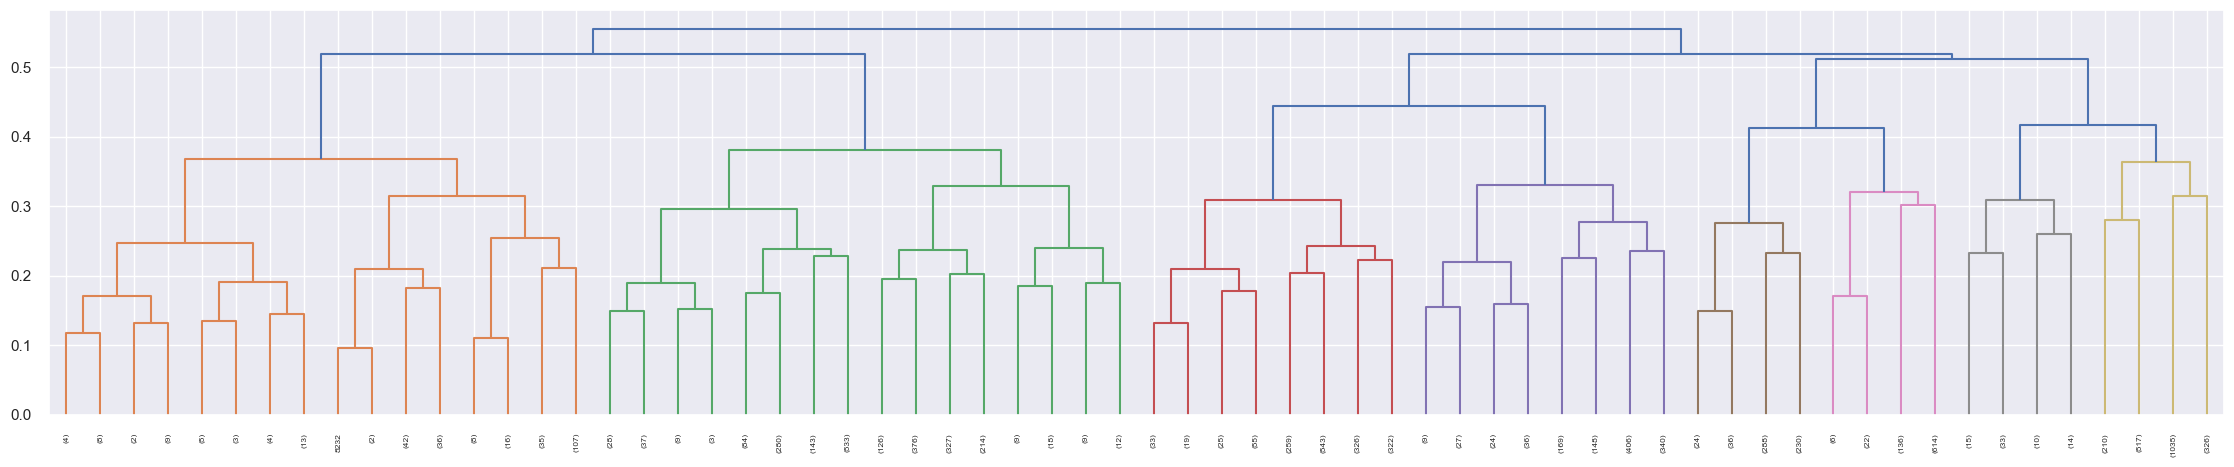

In [144]:
fig,axs = plt.subplots(1,1,figsize=(25,5))
dn = dendrogram(Z, truncate_mode='level',p=5, show_leaf_counts=True,ax=axs);
print(f"Leaves = {len(dn['leaves'])}")
plt.show()

In [145]:
cluster = AgglomerativeClustering(n_clusters = 3, affinity = 'precomputed', linkage ='average')
cluster.fit_predict(distance_matrix)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [146]:
gdv = squareform(distance_matrix,force='tovector')
Z = linkage(gdv,method='average')
c, coph_dists = cophenet(Z, gdv)

In [147]:
c

0.7202524157058854

In [149]:
hc_label = cluster.labels_ 
df_hc = df_gower.copy(deep=True)
df_hc['Clusters'] = hc_label

In [150]:
df_hc.groupby('Clusters').mean()

,hour,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall
Clusters,,,,,,,,,,
0,11.507089,729.962111,12.769129,58.081377,1.723400,14384.719409,3.917145,0.567827,0.149029,0.78351
1,11.500000,635.305556,12.995833,65.819444,2.015278,8978.333333,7.191667,0.572639,0.159722,0.00000
2,11.298305,0.000000,16.092881,60.494915,1.696949,15215.423729,7.770169,0.604780,0.136271,0.00000


In [153]:
df_hc.Clusters.value_counts(dropna=False)

0    8393
2     295
1      72
Name: Clusters, dtype: int64

### Hierarchical Clustering (numerical)

<Figure size 2000x1400 with 0 Axes>

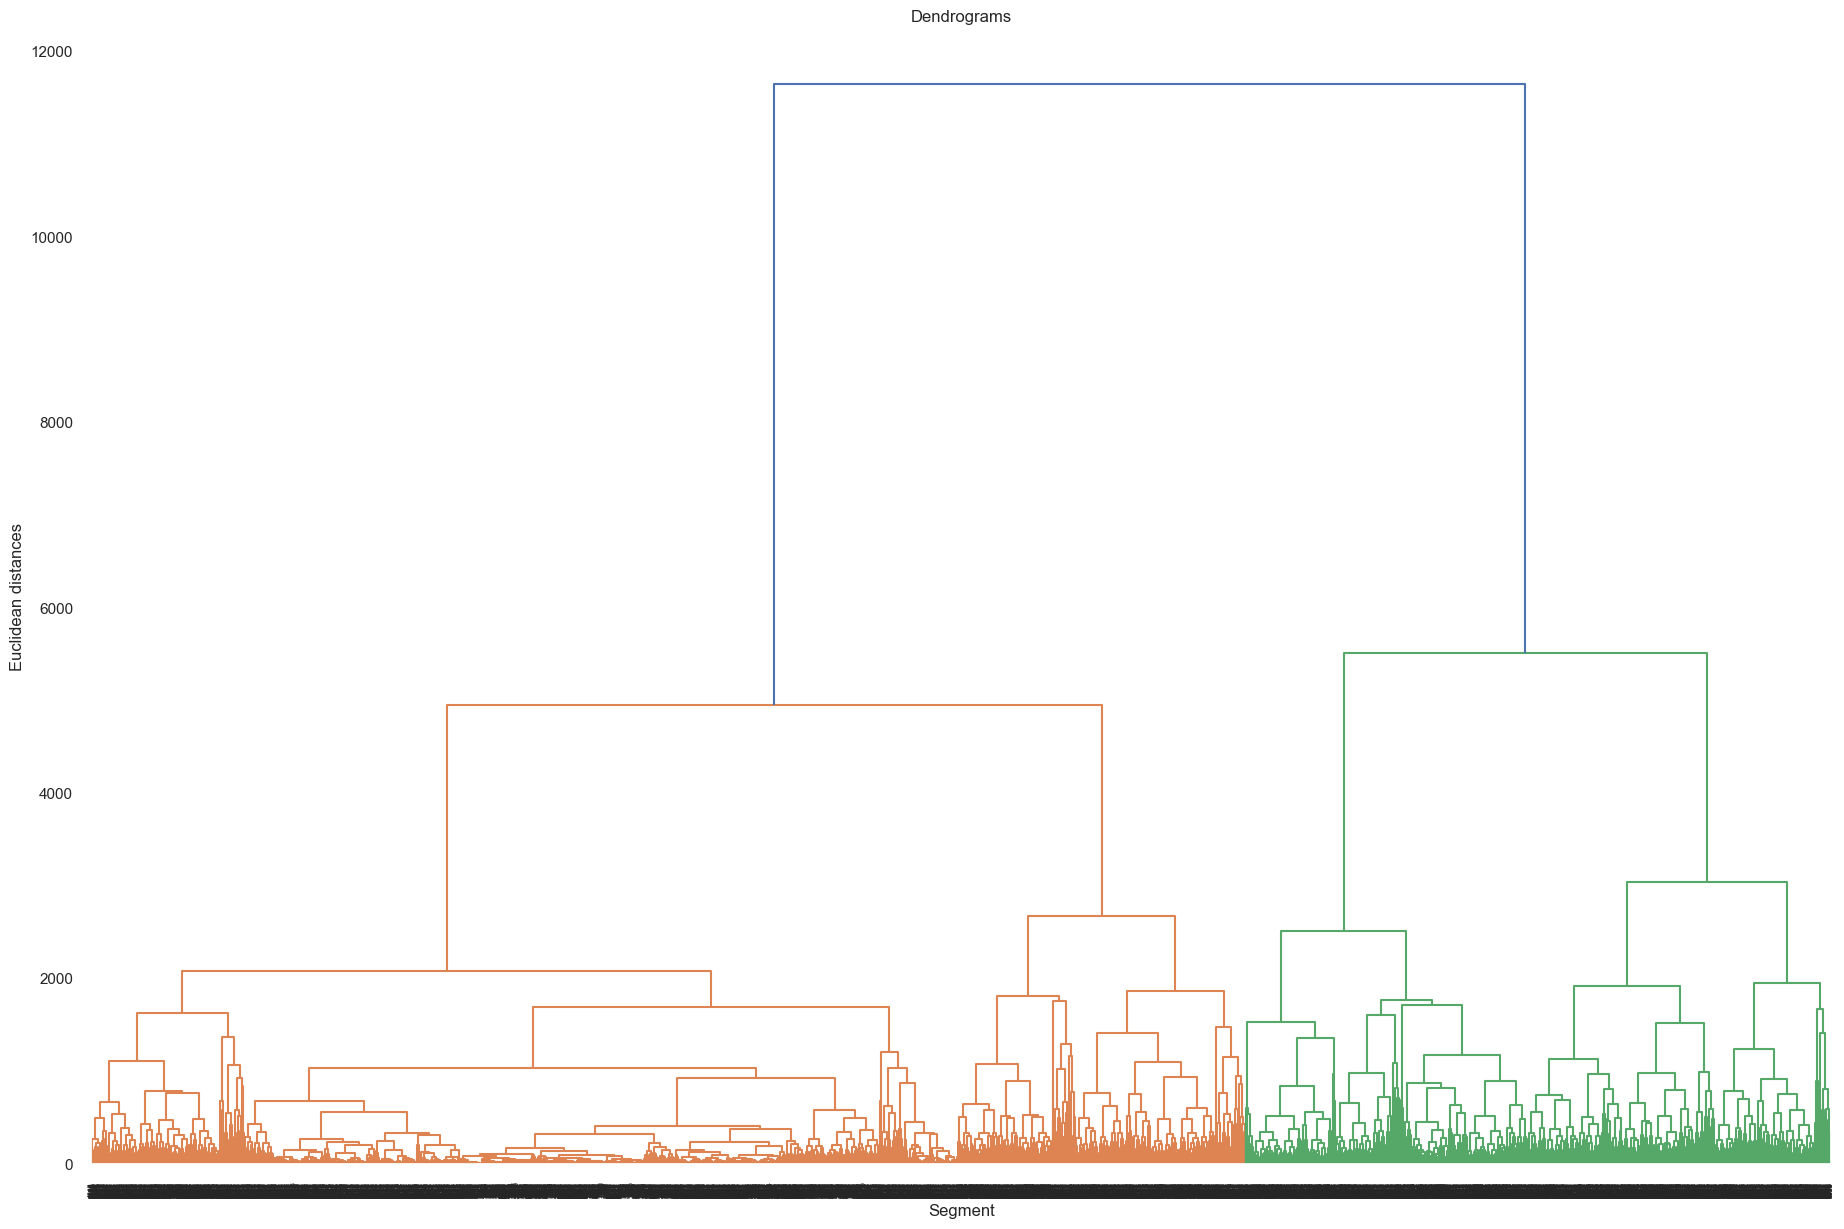

In [155]:
plt.figure(figsize=(20, 14)) 
dendrogram = dendrogram(linkage(df_kmean,method='average'))
plt.title("Dendrograms")  
plt.xlabel('Segment')
plt.ylabel('Euclidean distances')
plt.show()

In [164]:
hc1 = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='average')
hc1_Y = hc1.fit_predict(df_kmean)

In [165]:
hc_label1 = hc1.labels_ 
df_hc1 = df_kmean.copy(deep=True)
df_hc1['Clusters'] = hc_label1

In [166]:
Z1 = linkage(df_kmean, 'average')
c1, coph_dists1 = cophenet(Z1, pdist(df_kmean))

In [167]:
c

0.7202524157058854

In [168]:
df_hc1.groupby('Clusters').mean()

,hour,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall,k
Clusters,,,,,,,,,,,
0,11.922918,786.033035,13.037474,51.216449,1.834308,18273.795595,2.495716,0.655845,0.034085,0.426875,1.120096
1,11.021569,667.720915,14.139477,65.253595,1.574771,9287.444444,7.186471,0.527438,0.201242,0.923529,0.586928
2,10.282793,410.632581,10.893653,79.375176,1.438505,3842.630465,7.183498,0.258575,0.561707,1.891396,0.127645


In [169]:
df_hc1.Clusters.value_counts(dropna=False)

0    5812
1    1530
2    1418
Name: Clusters, dtype: int64